# `jax` + `haiku` + `optax` + `numpyro` implementation

In [4]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtree
import numpy as np
import scipy

import optax
import functools

import haiku as hk
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import os
import json
rngseed = 42
rngkeyseq = hk.PRNGSequence(jax.random.PRNGKey(rngseed))

In [5]:

@hk.transform
def forward(x):
    mlp = hk.nets.MLP(
        [num_hidden_nodes, output_dim], # WARNING: there are global variables 
        activation=activation_fn, 
        w_init=w_initialiser,
        with_bias=False
    )
    return mlp(x)

def loss_fn(params, x, y):
    y_pred = forward.apply(params, None, x)
    return jnp.mean(optax.l2_loss(y_pred, y))

def log_prior(params):
    param_array, _ = jtree.tree_flatten(params)
    result = 0.0
    for param in param_array:
        result += dist.Normal(loc=prior_mean, scale=prior_std).log_prob(param).sum()
    return result

def log_likelihood(params, x, y, sigma=1.0):
    y_hat = forward.apply(params, None, x)
    ydist = dist.Normal(y_hat, sigma)
    return ydist.log_prob(y).sum()

def log_posterior(params, x, y, itemp=1.0):
    return itemp * log_likelihood(params, x, y) + log_prior(params)


def numpyro_model(X, Y, shapes, treedef, itemp=1.0, sigma=0.1, prior_mean=0.0, prior_std=1.0):
    param_dict = normal_prior(shapes, treedef, prior_mean=prior_mean, prior_std=prior_std)
    y_hat = forward.apply(param_dict, None, X)
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("Y", dist.Normal(y_hat, sigma / jnp.sqrt(itemp)).to_event(1), obs=Y)
    return

def normal_prior(shapes, treedef, prior_mean=0.0, prior_std=1.0):
    result = []
    for i, shape in enumerate(shapes):
        result.append(numpyro.sample(str(i), dist.Normal(loc=prior_mean, scale=prior_std), sample_shape=shape))
    return treedef.unflatten(result)


def normal_localising_prior(params_center, std):
    result = []
    param_flat, treedef = jtree.tree_flatten(params_center)
    for i, p in enumerate(param_flat):
        result.append(numpyro.sample(str(i), dist.Normal(loc=p, scale=std)))
    return treedef.unflatten(result)


def expected_nll(param_list, X, Y, sigma):
    nlls = []
    for param in param_list:
        nlls.append(-log_likelihood(param, X, Y, sigma=sigma))
    return np.mean(nlls)

# Define training dataset

{"mlp/~/linear_0": {"w": [[-2.2342236042022705]]}, "mlp/~/linear_1": {"w": [[0.602609395980835]]}}


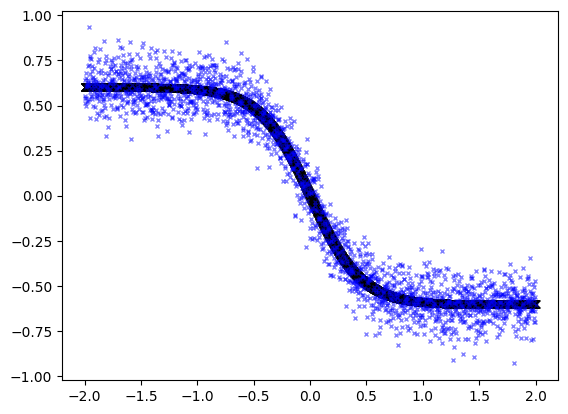

In [81]:
num_hidden_nodes = 1
output_dim = 1
num_training_data = 2023
activation_fn = jax.nn.tanh
sigma = 0.1
prior_std = 10.0
prior_mean = 0.0
w_initialiser = hk.initializers.RandomNormal(stddev=prior_std, mean=prior_mean)

X = jnp.linspace(-2, 2, num=num_training_data).reshape(-1, 1)
# w_0 = [
#     jnp.array([[0.5]]), 
#     jnp.array([[0.5]])
# ]
w_0 = [
    jax.random.uniform(next(rngkeyseq), (1, num_hidden_nodes), minval=-3, maxval=3), 
    jax.random.uniform(next(rngkeyseq), (num_hidden_nodes, 1), minval=-3, maxval=3), 
]

true_param = forward.init(next(rngkeyseq), X)
treedef = jtree.tree_structure(true_param)
true_param = treedef.unflatten(w_0)

print(json.dumps(jtree.tree_map(lambda x: x.tolist(), true_param)))

y_true = forward.apply(true_param, next(rngkeyseq), X)
Y = y_true + jax.random.normal(next(rngkeyseq), y_true.shape) * sigma

plt.plot(X, y_true, "kx--")
plt.plot(X, Y, "bx", markersize=3, alpha=0.5);

# Gradient descent

In [40]:
learning_rate = 0.1
max_num_epoch = 100

# optim = optax.sgd(learning_rate)
optim = optax.adam(learning_rate)

params = forward.init(next(rngkeyseq), X)
opt_state = optim.init(params)

sgd_rec = []
for _ in range(max_num_epoch):
    grads = jax.grad(loss_fn)(params, X, Y)
    updates, opt_state = optim.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    sgd_rec.append(params)

# Posterior sampling

In [41]:
num_warmup = 1000
num_posterior_samples = 2000
num_chains = 4
thinning = 4

init_params = params
shapes = [p.shape for p in jtree.tree_flatten(init_params)[0]]
treedef = jtree.tree_structure(init_params)

kernel = numpyro.infer.NUTS(
    numpyro_model,
#     step_size=eps, 
#     adapt_step_size=False
)
mcmc = numpyro.infer.MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_posterior_samples,
    num_chains=num_chains,
    thinning=thinning, 
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)
mcmc.run(
    next(rngkeyseq), 
    X, Y, 
    shapes, treedef,
    itemp=0.1, 
    sigma=sigma, 
    prior_mean=prior_mean, 
    prior_std=prior_std, 
#     init_params=jax.tree_util.tree_map(
#         lambda x: jnp.repeat(x * 0, num_chains, axis=-1).reshape(num_chains, *x.shape), 
#         init_params
#     )
)

posterior_sample_rec = mcmc.get_samples()

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_70671/2875780108.py:15: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|███████████████████████████████████████████| 3000/3000 [00:02<00:00, 1018.61it/s, 15 steps of size 5.61e-02. acc. prob=0.86]


In [42]:
x = mcmc.get_samples(group_by_chain=True)
for key in x.keys():
    print(x[key].shape)

num_mcmc_samples = x['0'].shape[1]
for chain_index in range(num_chains):
    print(chain_index, x['0'].shape)
    param_list = [
        [x[name][chain_index, i] for name in sorted(x.keys())]
        for i in range(num_mcmc_samples)
    ]
    print(param_list[0])
    break

(4, 500, 1, 2)
(4, 500, 2, 1)
0 (4, 500, 1, 2)
[Array([[ 3.0542138, -0.6079798]], dtype=float32), Array([[ 1.9146281],
       [-1.5637391]], dtype=float32)]


# RLCT estimation

In [61]:
num_itemps = 6
n = num_training_data
itemps = jnp.linspace(
    1 / jnp.log(n) * (1 - 1 / jnp.sqrt(2 * jnp.log(n))),
    1 / jnp.log(n) * (1 + 1 / jnp.sqrt(2 * jnp.log(n))), 
    num_itemps
)
print(f"itemps={itemps}")

num_warmup = 500
num_posterior_samples = 2000
num_chains = 4
thinning = 4
kernel = numpyro.infer.NUTS(
    numpyro_model,
)
mcmc = numpyro.infer.MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_posterior_samples,
    num_chains=num_chains,
    thinning=thinning, 
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

init_params = params
shapes = [p.shape for p in jtree.tree_flatten(init_params)[0]]
treedef = jtree.tree_structure(init_params)


enlls = []
for i_itemp, itemp in enumerate(itemps): 
    mcmc.run(
        next(rngkeyseq), 
        X, Y, 
        shapes, treedef,
        itemp=itemp, 
        sigma=sigma, 
        prior_mean=prior_mean,
        prior_std=prior_std, 
    )
    posterior_samples = mcmc.get_samples()
    num_mcmc_samples = num_mcmc_samples = len(posterior_samples[list(posterior_samples.keys())[0]])
    
    param_list = [
        [posterior_samples[name][i] for name in sorted(posterior_samples.keys())]
        for i in range(num_mcmc_samples)
    ]
    enll = expected_nll(map(treedef.unflatten, param_list), X, Y, sigma)
    enlls.append(enll)
    print(f"Finished {i_itemp} temp={1/itemp:.3f}. Expected NLL={enll:.3f}")
    if len(enlls) > 1:
        slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps[:len(enlls)], enlls)
        print(f"est. RLCT={slope:.3f}, energy={intercept / n:.3f}, r2={r_val**2:.3f}")

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_67324/3846077369.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


itemps=[0.09769844 0.11116536 0.12463227 0.13809918 0.15156609 0.165033  ]


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 2147.60it/s, 31 steps of size 9.23e-02. acc. prob=0.91]


Finished 0 temp=10.236. Expected NLL=-1769.759


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 2232.49it/s, 35 steps of size 9.35e-02. acc. prob=0.92]


Finished 1 temp=8.996. Expected NLL=-1770.804
est. RLCT=0.843, energy=-0.879, r2=1.000


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 2213.98it/s, 27 steps of size 1.07e-01. acc. prob=0.92]


Finished 2 temp=8.024. Expected NLL=-1771.457
est. RLCT=0.771, energy=-0.879, r2=0.996


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 2140.18it/s, 11 steps of size 8.86e-02. acc. prob=0.94]


Finished 3 temp=7.241. Expected NLL=-1772.377
est. RLCT=0.849, energy=-0.879, r2=0.990


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:01<00:00, 2275.75it/s, 7 steps of size 1.44e-01. acc. prob=0.92]


Finished 4 temp=6.598. Expected NLL=-1772.863
est. RLCT=0.858, energy=-0.879, r2=0.994


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:01<00:00, 2206.10it/s, 5 steps of size 1.39e-01. acc. prob=0.93]


Finished 5 temp=6.059. Expected NLL=-1773.413
est. RLCT=0.874, energy=-0.879, r2=0.995


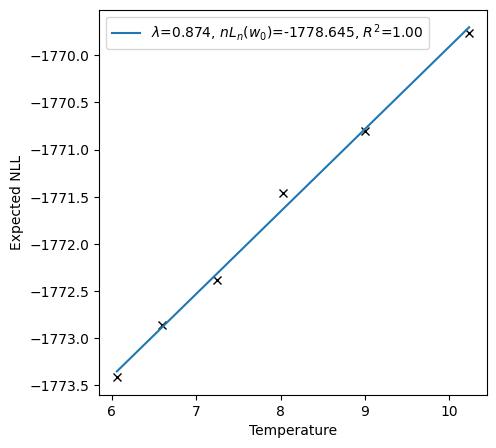

In [62]:
fig, ax = plt.subplots(figsize=(5,5))
slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps, enlls)
ax.plot(1/itemps, enlls, "kx")
ax.plot(1/itemps, 1/itemps * slope + intercept, 
        label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}, $R^2$={r_val**2:.2f}")
ax.legend()
ax.set_xlabel("Temperature")
ax.set_ylabel("Expected NLL");


# Visualisation (if 2D model)

## True regression function and dataset

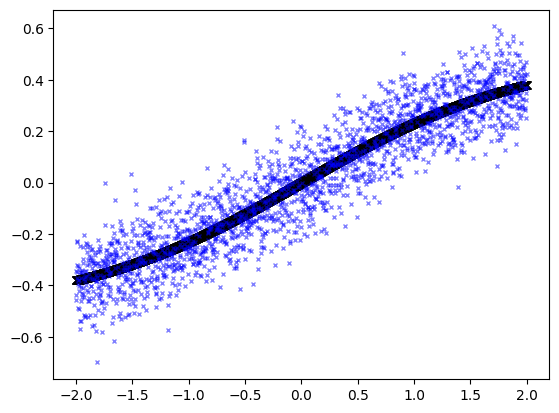

In [60]:
plt.plot(X, y_true, "kx--")
plt.plot(X, Y, "bx", markersize=3, alpha=0.5);

## SGD trajectory + posterior samples

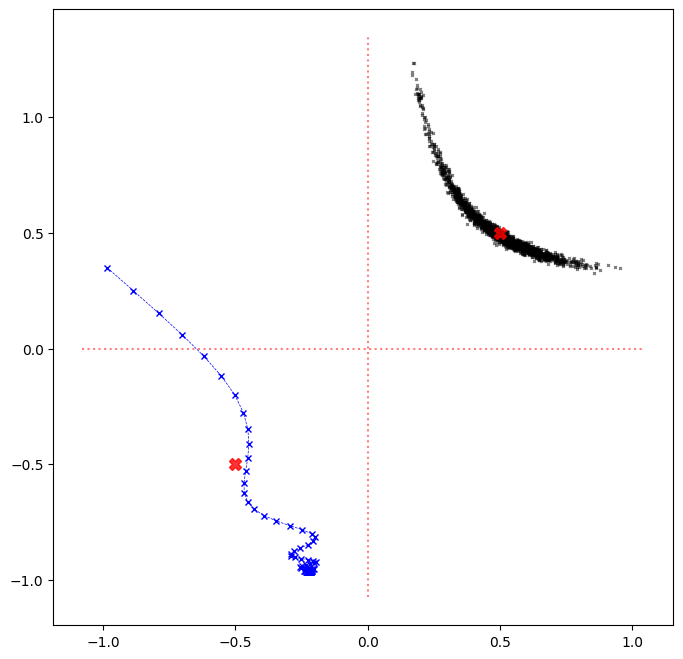

In [66]:
fig, ax = plt.subplots(figsize=(8, 8))

#posterior samples 
(s1, s2), _ = jax.tree_util.tree_flatten(posterior_sample_rec)
ax.plot(s1[:, 1, 1], s2[:, 1, 1], "kx", alpha=0.5, markersize=2)

# SGD trajectory
ws = jnp.vstack([jnp.hstack(jtree.tree_flatten(elem)[0]) for elem in sgd_rec])
ax.plot(ws[:, 0], ws[:, 1], "bx--", linewidth=0.5, markersize=5)

# True parameter
ws_true = np.hstack(jtree.tree_flatten(true_param)[0]).ravel()
ax.plot([ws_true[0]], [ws_true[1]], "rX", markersize=8, alpha=.8)
ax.plot([-ws_true[0]], [-ws_true[1]], "rX", markersize=8, alpha=.8)

# axes
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.vlines([0], ymin=ymin, ymax=ymax, color='r', linestyle="dotted", alpha=0.5)
ax.hlines([0], xmin=xmin, xmax=xmax, color='r', linestyle="dotted", alpha=0.5)

## Posterior samples

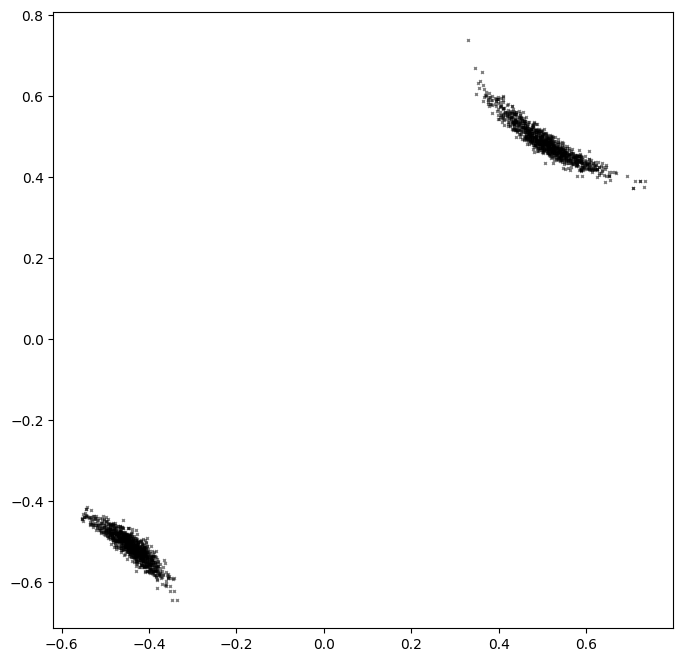

In [49]:
(s1, s2), _ = jax.tree_util.tree_flatten(posterior_sample_rec)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(s1[:, 1, 1], s2[:, 1, 1], "kx", alpha=0.5, markersize=2)

# Ensemble of SGD-endpoints

In [14]:
learning_rate = 0.1
max_num_epoch = 100
ensemble_size = 50
# optim = optax.sgd(learning_rate)
# optim = optax.adam(learning_rate)
optim = optax.noisy_sgd(learning_rate, eta=0.2, gamma=0.5,)


sgd_ensemble_rec = {}
for e in range(ensemble_size):
    params = forward.init(next(rngkeyseq), X)
#     params = sgd_rec[-1]
#     params = jtree.tree_map(lambda x: 0 * x, params)
    opt_state = optim.init(params)

    rec = []
    for _ in range(max_num_epoch):
        grads = jax.grad(loss_fn)(params, X, Y)
        updates, opt_state = optim.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        rec.append(params)
    
    sgd_ensemble_rec[e] = rec
    print(f"Finished: {e}")

Finished: 0
Finished: 1
Finished: 2
Finished: 3
Finished: 4
Finished: 5
Finished: 6
Finished: 7
Finished: 8
Finished: 9
Finished: 10
Finished: 11
Finished: 12
Finished: 13
Finished: 14
Finished: 15
Finished: 16
Finished: 17
Finished: 18
Finished: 19
Finished: 20
Finished: 21
Finished: 22
Finished: 23
Finished: 24
Finished: 25
Finished: 26
Finished: 27
Finished: 28
Finished: 29
Finished: 30
Finished: 31
Finished: 32
Finished: 33
Finished: 34
Finished: 35
Finished: 36
Finished: 37
Finished: 38
Finished: 39
Finished: 40
Finished: 41
Finished: 42
Finished: 43
Finished: 44
Finished: 45
Finished: 46
Finished: 47
Finished: 48
Finished: 49


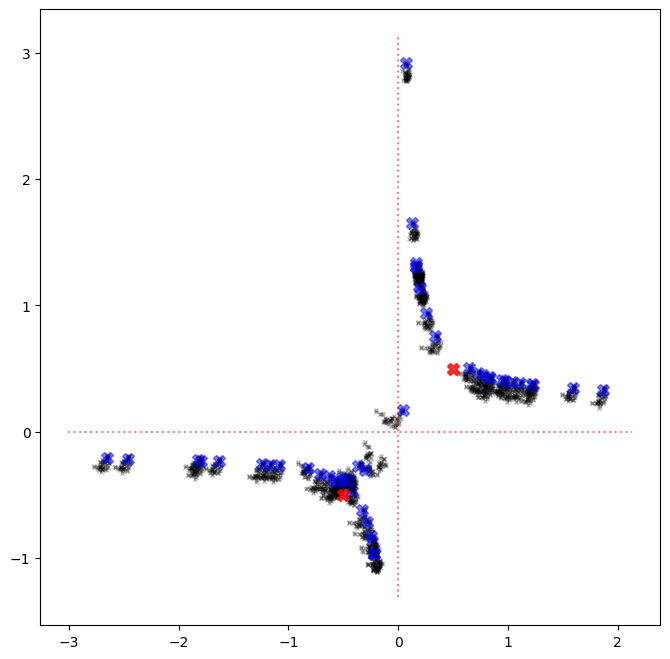

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

PLOT_TRAJECTORY = True
sgd_burn = 50 # start index for plotting sgd trajectory
for e, rec in sgd_ensemble_rec.items():
    ws = jnp.vstack([jnp.hstack(jtree.tree_flatten(elem)[0]) for elem in rec])
    if PLOT_TRAJECTORY:
        ax.plot(ws[sgd_burn:, 0], ws[sgd_burn:, 1], "kx--", linewidth=0.2, markersize=3, alpha=0.3)
    ax.plot([ws[-1, 0]], [ws[-1, 1]], "bX", markersize=8, alpha=.5)


# True parameter
ws_true = np.hstack(jtree.tree_flatten(true_param)[0]).ravel()
ax.plot([ws_true[0]], [ws_true[1]], "rX", markersize=8, alpha=.8)
ax.plot([-ws_true[0]], [-ws_true[1]], "rX", markersize=8, alpha=.8)

# axes
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.vlines([0], ymin=ymin, ymax=ymax, color='r', linestyle="dotted", alpha=0.5)
ax.hlines([0], xmin=xmin, xmax=xmax, color='r', linestyle="dotted", alpha=0.5)

# set axes limits
# lim = 1.0
# ax.set_xlim(-lim, lim)
# ax.set_ylim(-lim, lim)

# Energy, $\lambda$ estimates for multiple `n`'s

In [6]:
%time 

w_0 = [
    jnp.array([[0.1, 0.2, 0.01]]), 
    jnp.array([[0.02, -0.1, 0.5]]).T
]
input_dim, num_hidden_nodes = w_0[0].shape
output_dim = w_0[1].shape[1]
activation_fn = jax.nn.tanh

@hk.transform
def forward(x):
    mlp = hk.nets.MLP(
        [num_hidden_nodes, output_dim], # WARNING: there are global variables 
        activation=activation_fn, 
        w_init=w_initialiser,
        with_bias=False
    )
    return mlp(x)


sigma = 0.1
prior_std = 1.0
prior_mean = 0.0
w_initialiser = hk.initializers.RandomNormal(stddev=prior_std, mean=prior_mean)
num_itemps = 6

X = jax.random.uniform(
    key=next(rngkeyseq), 
    shape=(3, input_dim), 
    minval=-2, 
    maxval=2
)
true_param = forward.init(next(rngkeyseq), X)
treedef = jtree.tree_structure(true_param)
true_param = treedef.unflatten(w_0)
true_param_flat, treedef = jtree.tree_flatten(true_param)
shapes = [p.shape for p in true_param_flat]
print(true_param)

num_warmup = 500
num_posterior_samples = 2000
num_chains = 4
thinning = 4
kernel = numpyro.infer.NUTS(numpyro_model)
mcmc = numpyro.infer.MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_posterior_samples,
    num_chains=num_chains,
    thinning=thinning, 
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

# ns = [50, 100, 200, 300, 500]
ns = [100, 500, 1000, 2000, 5000]
run_rec = {}
for num_training_data in ns:
    X = jax.random.uniform(
        key=next(rngkeyseq), 
        shape=(num_training_data, input_dim), 
        minval=-2, 
        maxval=2
    )
    y_true = forward.apply(true_param, next(rngkeyseq), X)
    Y = y_true + jax.random.normal(next(rngkeyseq), y_true.shape) * sigma
    n = num_training_data
    itemps = jnp.linspace(
        1 / jnp.log(n) * (1 - 1 / jnp.sqrt(2 * jnp.log(n))),
        1 / jnp.log(n) * (1 + 1 / jnp.sqrt(2 * jnp.log(n))), 
        num_itemps
    )
    print(f"itemps={itemps}")

    enlls = []
    for i_itemp, itemp in enumerate(itemps): 
        mcmc.run(
            next(rngkeyseq), 
            X, Y, 
            shapes, treedef,
            itemp=itemp, 
            sigma=sigma, 
            prior_mean=prior_mean,
            prior_std=prior_std, 
        )
        posterior_samples = mcmc.get_samples()
        num_mcmc_samples = len(posterior_samples[list(posterior_samples.keys())[0]])

        param_list = [
            [posterior_samples[name][i] for name in sorted(posterior_samples.keys())]
            for i in range(num_mcmc_samples)
        ]
        enll = expected_nll(map(treedef.unflatten, param_list), X, Y, sigma)
        enlls.append(enll)
        print(f"Finished {i_itemp} temp={1/itemp:.3f}. Expected NLL={enll:.3f}")
        if len(enlls) > 1:
            slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps[:len(enlls)], enlls)
            print(f"est. RLCT={slope:.3f}, energy={intercept / n:.3f}, r2={r_val**2:.3f}")
    
    run_rec[num_training_data] = {
        "itemps": itemps, "enlls": enlls, "slope": slope, "intercept": intercept, "rval": r_val
    }
    print(f"Finished (n={num_training_data}): RLCT est={slope:.3f}, energy={intercept / n:.3f}")

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 1.91 µs
{'mlp/~/linear_0': {'w': Array([[0.1 , 0.2 , 0.01]], dtype=float32)}, 'mlp/~/linear_1': {'w': Array([[ 0.02],
       [-0.1 ],
       [ 0.5 ]], dtype=float32)}}
itemps=[0.14559612 0.17421657 0.20283702 0.23145746 0.2600779  0.28869835]


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_74637/2173893162.py:46: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 1856.71it/s, 87 steps of size 4.87e-02. acc. prob=0.72]


Finished 0 temp=6.868. Expected NLL=-95.491


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:01<00:00, 2347.51it/s, 3 steps of size 3.47e-02. acc. prob=0.11]


Finished 1 temp=5.740. Expected NLL=-96.380
est. RLCT=0.788, energy=-1.009, r2=1.000


sample: 100%|██████████████████████████████████████████| 2500/2500 [00:01<00:00, 1365.72it/s, 255 steps of size 1.96e-02. acc. prob=0.95]


Finished 2 temp=4.930. Expected NLL=-96.792
est. RLCT=0.678, energy=-1.002, r2=0.987


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 1518.85it/s, 63 steps of size 2.36e-02. acc. prob=0.85]


Finished 3 temp=4.320. Expected NLL=-97.132
est. RLCT=0.640, energy=-0.999, r2=0.988


sample: 100%|██████████████████████████████████████████| 2500/2500 [00:01<00:00, 1367.19it/s, 127 steps of size 2.17e-02. acc. prob=0.92]


Finished 4 temp=3.845. Expected NLL=-97.695
est. RLCT=0.687, energy=-1.002, r2=0.986


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:02<00:00, 1235.81it/s, 63 steps of size 2.40e-02. acc. prob=0.91]


Finished 5 temp=3.464. Expected NLL=-97.846
est. RLCT=0.686, energy=-1.002, r2=0.990
Finished (n=100): RLCT est=0.686, energy=-1.002
itemps=[0.11526922 0.13352601 0.1517828  0.17003958 0.18829636 0.20655315]


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:05<00:00, 445.26it/s, 191 steps of size 1.81e-02. acc. prob=0.90]


Finished 0 temp=8.675. Expected NLL=-454.211


sample: 100%|█████████████████████████████████████████████| 2500/2500 [00:04<00:00, 590.22it/s, 3 steps of size 1.44e-02. acc. prob=0.57]


Finished 1 temp=7.489. Expected NLL=-455.340
est. RLCT=0.951, energy=-0.925, r2=1.000


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:05<00:00, 438.06it/s, 191 steps of size 1.51e-02. acc. prob=0.83]


Finished 2 temp=6.588. Expected NLL=-455.947
est. RLCT=0.838, energy=-0.923, r2=0.991


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:07<00:00, 346.74it/s, 511 steps of size 1.22e-02. acc. prob=0.92]


Finished 3 temp=5.881. Expected NLL=-456.605
est. RLCT=0.842, energy=-0.923, r2=0.996


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:07<00:00, 346.75it/s, 379 steps of size 1.20e-02. acc. prob=0.92]


Finished 4 temp=5.311. Expected NLL=-457.123
est. RLCT=0.850, energy=-0.923, r2=0.997


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:06<00:00, 357.79it/s, 255 steps of size 1.23e-02. acc. prob=0.88]


Finished 5 temp=4.841. Expected NLL=-457.200
est. RLCT=0.803, energy=-0.923, r2=0.990
Finished (n=500): RLCT est=0.803, energy=-0.923
itemps=[0.10581733 0.12139633 0.13697533 0.15255432 0.16813332 0.18371232]


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:09<00:00, 263.84it/s, 127 steps of size 1.75e-02. acc. prob=0.80]


Finished 0 temp=9.450. Expected NLL=-880.260


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:13<00:00, 191.94it/s, 255 steps of size 1.26e-02. acc. prob=0.86]


Finished 1 temp=8.237. Expected NLL=-881.276
est. RLCT=0.838, energy=-0.888, r2=1.000


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:13<00:00, 182.02it/s, 255 steps of size 1.23e-02. acc. prob=0.89]


Finished 2 temp=7.301. Expected NLL=-882.398
est. RLCT=0.987, energy=-0.890, r2=0.990


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:06<00:00, 401.96it/s, 111 steps of size 1.26e-02. acc. prob=0.32]


Finished 3 temp=6.555. Expected NLL=-882.894
est. RLCT=0.939, energy=-0.889, r2=0.992


sample: 100%|█████████████████████████████████████████████| 2500/2500 [00:03<00:00, 665.07it/s, 7 steps of size 1.29e-02. acc. prob=0.12]


Finished 4 temp=5.948. Expected NLL=-883.716
est. RLCT=0.977, energy=-0.889, r2=0.993


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:12<00:00, 196.59it/s, 255 steps of size 1.56e-02. acc. prob=0.84]


Finished 5 temp=5.443. Expected NLL=-883.698
est. RLCT=0.913, energy=-0.889, r2=0.984
Finished (n=1000): RLCT est=0.913, energy=-0.889
itemps=[0.09782004 0.11131736 0.12481467 0.13831198 0.15180929 0.1653066 ]


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:26<00:00, 95.54it/s, 255 steps of size 1.24e-02. acc. prob=0.86]


Finished 0 temp=10.223. Expected NLL=-1768.186


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:28<00:00, 86.55it/s, 511 steps of size 1.14e-02. acc. prob=0.86]


Finished 1 temp=8.983. Expected NLL=-1769.449
est. RLCT=1.019, energy=-0.889, r2=1.000


sample: 100%|██████████████████████████████████████████████| 2500/2500 [00:30<00:00, 82.79it/s, 3 steps of size 9.68e-03. acc. prob=0.84]


Finished 2 temp=8.012. Expected NLL=-1770.049
est. RLCT=0.851, energy=-0.888, r2=0.983


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:25<00:00, 97.12it/s, 127 steps of size 1.19e-02. acc. prob=0.81]


Finished 3 temp=7.230. Expected NLL=-1770.201
est. RLCT=0.687, energy=-0.888, r2=0.936


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:40<00:00, 61.16it/s, 511 steps of size 7.71e-03. acc. prob=0.93]


Finished 4 temp=6.587. Expected NLL=-1771.387
est. RLCT=0.789, energy=-0.888, r2=0.946


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:43<00:00, 57.87it/s, 511 steps of size 7.15e-03. acc. prob=0.91]


Finished 5 temp=6.049. Expected NLL=-1771.729
est. RLCT=0.815, energy=-0.888, r2=0.963
Finished (n=2000): RLCT est=0.815, energy=-0.888
itemps=[0.08896232 0.10034122 0.11172013 0.12309903 0.13447793 0.14585683]


sample: 100%|████████████████████████████████████████████| 2500/2500 [01:19<00:00, 31.63it/s, 127 steps of size 1.25e-02. acc. prob=0.74]


Finished 0 temp=11.241. Expected NLL=-4404.948


sample: 100%|████████████████████████████████████████████| 2500/2500 [02:17<00:00, 18.20it/s, 511 steps of size 7.98e-03. acc. prob=0.90]


Finished 1 temp=9.966. Expected NLL=-4405.092
est. RLCT=0.113, energy=-0.881, r2=1.000


sample: 100%|████████████████████████████████████████████| 2500/2500 [02:36<00:00, 16.02it/s, 255 steps of size 6.84e-03. acc. prob=0.92]


Finished 2 temp=8.951. Expected NLL=-4406.496
est. RLCT=0.652, energy=-0.882, r2=0.766


sample: 100%|█████████████████████████████████████████████| 2500/2500 [02:50<00:00, 14.64it/s, 15 steps of size 5.54e-03. acc. prob=0.91]


Finished 3 temp=8.124. Expected NLL=-4407.251
est. RLCT=0.781, energy=-0.883, r2=0.886


sample: 100%|████████████████████████████████████████████| 2500/2500 [01:43<00:00, 24.05it/s, 263 steps of size 9.36e-03. acc. prob=0.81]


Finished 4 temp=7.436. Expected NLL=-4407.876
est. RLCT=0.830, energy=-0.883, r2=0.932


sample: 100%|███████████████████████████████████████████| 2500/2500 [01:49<00:00, 22.77it/s, 1023 steps of size 8.49e-03. acc. prob=0.84]


Finished 5 temp=6.856. Expected NLL=-4408.450
est. RLCT=0.861, energy=-0.883, r2=0.953
Finished (n=5000): RLCT est=0.861, energy=-0.883


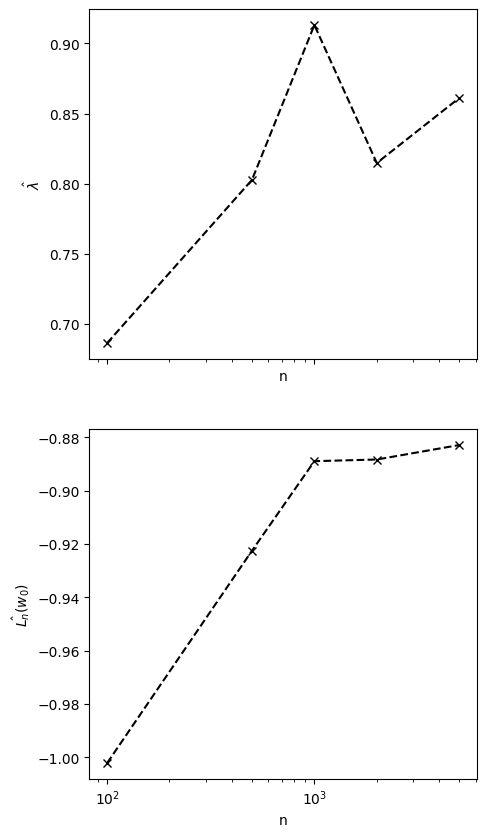

In [7]:
nums = sorted(run_rec.keys())
lambdas = [run_rec[n]["slope"] for n in nums]
energies = [run_rec[n]["intercept"] / n for n in nums]

fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
ax = axes[0]
ax.plot(nums, lambdas, "kx--")
ax.set_xlabel("n")
ax.set_ylabel("$\hat{\lambda}$")
ax.set_xscale("log")

ax = axes[1]
ax.plot(nums, energies, "kx--")
ax.set_xlabel("n")
ax.set_ylabel("$\hat{L_n}(w_0)$");


# `numpyro` with minibatching

In [11]:
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMCECS, NUTS

# Generate synthetic data
num_features = 3
num_samples = 10000
rng_key = random.PRNGKey(0)
true_w = jnp.array([1.0, -0.5, 2.0])
X = random.normal(rng_key, (num_samples, num_features))
y = jnp.dot(X, true_w) + 0.1 * random.normal(rng_key, (num_samples,))

def model(X, y, batch_size=None):
    num_features = X.shape[1]
    w = numpyro.sample("w", dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))

    if batch_size is not None:
        with numpyro.plate("N", X.shape[0], subsample_size=batch_size):
            X_batch = numpyro.subsample(X, event_dim=1)
            y_batch = numpyro.subsample(y, event_dim=0)
    else:
        X_batch, y_batch = X, y

    mean = jnp.dot(X_batch, w)
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    with numpyro.plate("data", X_batch.shape[0]):
        numpyro.sample("y", dist.Normal(mean, sigma), obs=y_batch)

# Inference
kernel = HMCECS(NUTS(model))
mcmc = MCMC(kernel, num_warmup=500, num_samples=2000)
mcmc.run(random.PRNGKey(1), X, y, batch_size=1000)
mcmc.print_summary()


sample: 100%|█████████████████████████████████████████████| 2500/2500 [00:03<00:00, 736.80it/s, 7 steps of size 3.62e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.09      0.00      0.09      0.09      0.10    959.37      1.02
      w[0]      1.00      0.00      1.00      1.00      1.01     98.89      1.03
      w[1]     -0.50      0.00     -0.50     -0.51     -0.49      6.32      1.27
      w[2]      1.99      0.00      1.99      1.99      2.00     21.72      1.08

